In [101]:
# Import Necessary Libraries
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import joblib
import numpy as np
import pickle

In [102]:
#Load the preprocessed data
preprocessed_data = pd.read_csv('preprocessed_data.csv')

In [103]:
#Top 5 entries
preprocessed_data.head()

,User,Transaction,Tag
0,User10,mg bangalore,Medical
1,User3,amazon bangalore,Shopping
2,User6,ravi medicine bangalore,Medical
3,User6,columbia asia bangalore,Medical
4,User9,meghna foods bangalore,Food


We maintain the list of users because we use user as a feature for the training dataset, when a new user comes in we will specify a value that is not in the user_available list,probably that will help model understand that this is a new user and he
has no prior taggings available.

In [104]:
# We maintain the list of users because we use user as a feature for the training dataset
users_available = preprocessed_data['User'].tolist()
# Dump these Users
with open('users_available.pkl', 'wb') as f:
    # Write the list to the file
    pickle.dump(users_available, f)

For our use case we would need best performing Multilingual Embeddings. So lets head over to the MTEB leaderboard and pick one from there

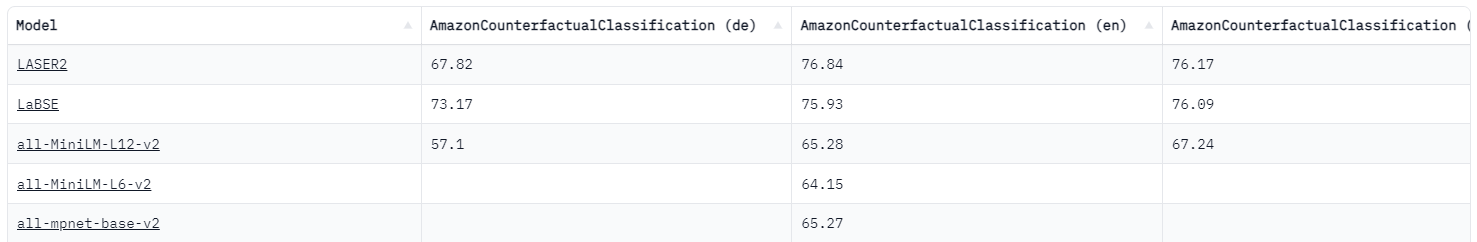

We Have two options whether to use a large parameter model or a small parater model. (Tradeoff between Accuracy and Latency)

In [105]:
## Let us try with all-MiniLM-L6-v2
from sentence_transformers import SentenceTransformer
sentences = preprocessed_data['Transaction'].to_list()

In [106]:
# Lets get the embeddings from the sentances
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings)

[[-0.04322374 -0.01268452  0.00395562 ... -0.05064136 -0.11488947
  -0.0854646 ]
 [ 0.02242737 -0.0295487  -0.07189132 ... -0.07091721 -0.06124997
  -0.0112023 ]
 [-0.06130331  0.01692494 -0.0566077  ... -0.06592673 -0.02916417
  -0.02086799]
 ...
 [-0.01009273 -0.04832548 -0.04341302 ... -0.05622667 -0.06757103
  -0.04366802]
 [ 0.04578929  0.02650515 -0.03105507 ... -0.02454238 -0.03998293
  -0.03701015]
 [-0.01315921 -0.02102073  0.00700834 ... -0.08375841  0.00316238
  -0.04991223]]


In [107]:
# Concat these embeddings to the file
embeddings_dataset = pd.concat([preprocessed_data,pd.DataFrame(embeddings)],axis=1)

In [108]:
# Top 5 entries
embeddings_dataset.head()

,User,Transaction,Tag,0,1,2,3,4,5,6,...,374,375,376,377,378,379,380,381,382,383
0,User10,mg bangalore,Medical,-0.043224,-0.012685,0.003956,0.040189,-0.085170,-0.005057,0.052504,...,0.013078,0.051690,-0.042813,-0.044552,-0.048992,-0.001867,0.028403,-0.050641,-0.114889,-0.085465
1,User3,amazon bangalore,Shopping,0.022427,-0.029549,-0.071891,0.036993,-0.008657,0.041752,-0.044857,...,0.010486,0.026003,-0.066787,-0.051076,-0.027117,0.111215,0.089663,-0.070917,-0.061250,-0.011202
2,User6,ravi medicine bangalore,Medical,-0.061303,0.016925,-0.056608,0.024087,-0.058576,0.024351,0.017888,...,-0.074376,0.034535,-0.060439,-0.056292,-0.052263,0.025619,0.043099,-0.065927,-0.029164,-0.020868
3,User6,columbia asia bangalore,Medical,0.033344,0.009651,-0.023548,0.033597,-0.070821,0.023675,-0.006321,...,0.032060,0.048686,-0.072227,-0.026805,-0.019570,0.109888,0.026178,-0.061520,-0.093940,-0.021665
4,User9,meghna foods bangalore,Food,-0.036506,-0.024542,-0.048879,0.048593,-0.079268,0.097876,-0.055953,...,-0.027787,0.078949,-0.075628,0.023413,0.014441,0.013229,0.010613,-0.029405,-0.041154,-0.031360


In [109]:
# Replace User with '' to make it int
embeddings_dataset['User_id'] = embeddings_dataset['User'].str.replace('User','')
# Change the datatype of the UserId from string to the integer
embeddings_dataset['User_id'] = embeddings_dataset['User_id'].astype(int)

In [110]:
# Column names can't be of mixed datatype therefore change it to string 
num_dimensions = 384
column_mapping = {i: f'Feature{i}' for i in range(num_dimensions+1)}
embeddings_dataset = embeddings_dataset.rename(columns=column_mapping)

In [111]:
# Prepare your featureset and the target variable
X = embeddings_dataset.drop(columns=['Tag','User','Transaction'])
y = embeddings_dataset['Tag']
# Split your data into training and test sets using stratified split on the user_id. We want all users to be in the training set.
# Will discuss why we want such a behaviour. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify =embeddings_dataset['User_id'] ,random_state=42)

In [112]:
X_train.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature375,Feature376,Feature377,Feature378,Feature379,Feature380,Feature381,Feature382,Feature383,User_id
466,-0.061607,0.021109,-0.029507,0.050608,0.001134,0.005973,0.040485,0.028323,-0.034021,0.046917,...,0.055946,-0.067546,-0.101885,-0.006615,0.073394,0.066049,-0.001069,-0.073724,-0.023892,13
129,-0.025332,-0.051232,-0.100755,0.055770,-0.009053,-0.016233,0.007624,0.025452,-0.021775,-0.015170,...,0.064789,-0.051988,-0.059050,-0.063797,0.078680,0.077889,-0.029503,-0.051294,-0.037061,14
940,-0.013159,-0.021021,0.007008,-0.022461,0.002843,0.021604,0.028168,0.084881,-0.046810,-0.008587,...,0.019474,-0.091984,-0.030931,-0.078524,0.062954,-0.054538,-0.083758,0.003162,-0.049912,12
730,-0.014338,0.036519,-0.030587,-0.043091,-0.097023,0.038005,-0.047036,-0.017092,-0.057033,0.007419,...,0.151159,-0.095012,-0.085966,-0.076053,0.035824,0.032255,-0.076523,-0.043340,-0.072152,14
210,0.020997,-0.052240,-0.077261,-0.066575,0.055326,0.087589,-0.029689,0.046233,-0.017779,-0.011467,...,0.066864,-0.018092,-0.051249,-0.065001,0.036361,0.145354,0.001424,-0.049648,-0.069986,1
